In [66]:
#!pip install missingno
#!pip install xgboost
#!pip install lightgbm

In [2]:
import pandas as pd
import numpy as np
import os
from os.path import join
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
import lightgbm
import missingno
import sklearn
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


print(xgboost.__version__)
print(lightgbm.__version__)
print(missingno.__version__)
print(sklearn.__version__)

2.1.4
4.6.0
0.5.2
0.24.1


## 1. 데이터 불러오기 밑 타겟 분류

In [3]:
#data_dir = os.path.join(os.getenv("HOME"), 'work/kaggle_kakr_housing/data')
data_dir = 'C:/Users/USER/Desktop/AIFFEL/work/kaggle_kakr_housing/data'

train_data_path = os.path.join(data_dir, 'train.csv')
test_data_path = os.path.join(data_dir, 'test.csv')

train= pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6468 entries, 0 to 6467
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             6468 non-null   int64  
 1   date           6468 non-null   object 
 2   bedrooms       6468 non-null   int64  
 3   bathrooms      6468 non-null   float64
 4   sqft_living    6468 non-null   int64  
 5   sqft_lot       6468 non-null   int64  
 6   floors         6468 non-null   float64
 7   waterfront     6468 non-null   int64  
 8   view           6468 non-null   int64  
 9   condition      6468 non-null   int64  
 10  grade          6468 non-null   int64  
 11  sqft_above     6468 non-null   int64  
 12  sqft_basement  6468 non-null   int64  
 13  yr_built       6468 non-null   int64  
 14  yr_renovated   6468 non-null   int64  
 15  zipcode        6468 non-null   int64  
 16  lat            6468 non-null   float64
 17  long           6468 non-null   float64
 18  sqft_liv

In [6]:
train.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [7]:
test.columns

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [8]:
train['date'] = train['date'].apply(lambda x : str(x[:6])).astype(int)
test['date'] = test['date'].apply(lambda x : str(x[:6])).astype(int)

train.head()

id    date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0   0  201410  221900.0         3       1.00         1180      5650     1.0   
1   1  201502  180000.0         2       1.00          770     10000     1.0   
2   2  201502  510000.0         3       2.00         1680      8080     1.0   
3   3  201406  257500.0         3       2.25         1715      6819     2.0   
4   4  201501  291850.0         3       1.50         1060      9711     1.0   

   waterfront  view  ...  grade  sqft_above  sqft_basement  yr_built  \
0           0     0  ...      7        1180              0      1955   
1           0     0  ...      6         770              0      1933   
2           0     0  ...      8        1680              0      1987   
3           0     0  ...      7        1715              0      1995   
4           0     0  ...      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503  
3             0    98003  47.3097 -122.327           2238        6819  
4             0    98198  47.4095 -122.315           1650        9711  

[5 rows x 21 columns]

## 2. EDA

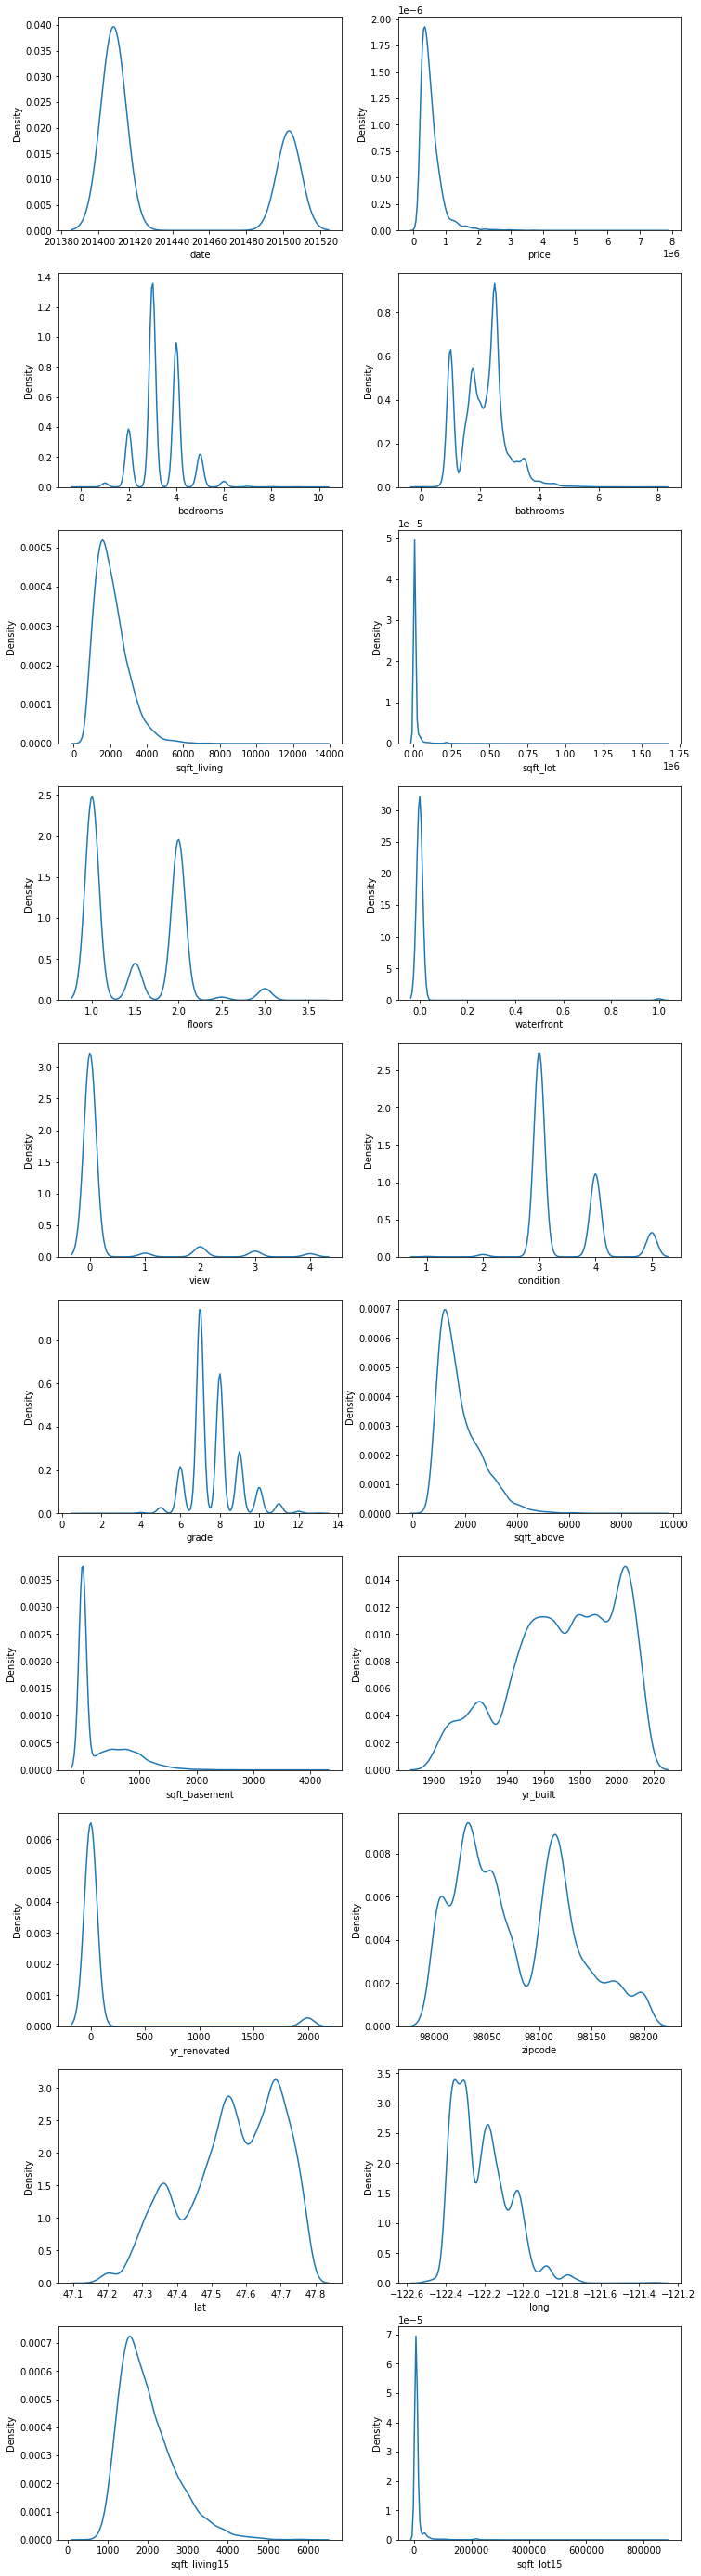

In [9]:
fig, ax = plt.subplots(10, 2, figsize=(12,50))

count = 1
columns = train.columns

for row in range(10):
    for col in range(2):
        sns.kdeplot(data = train[columns[count]], ax=ax[row][col])
        count += 1
        if count == 19:
            break

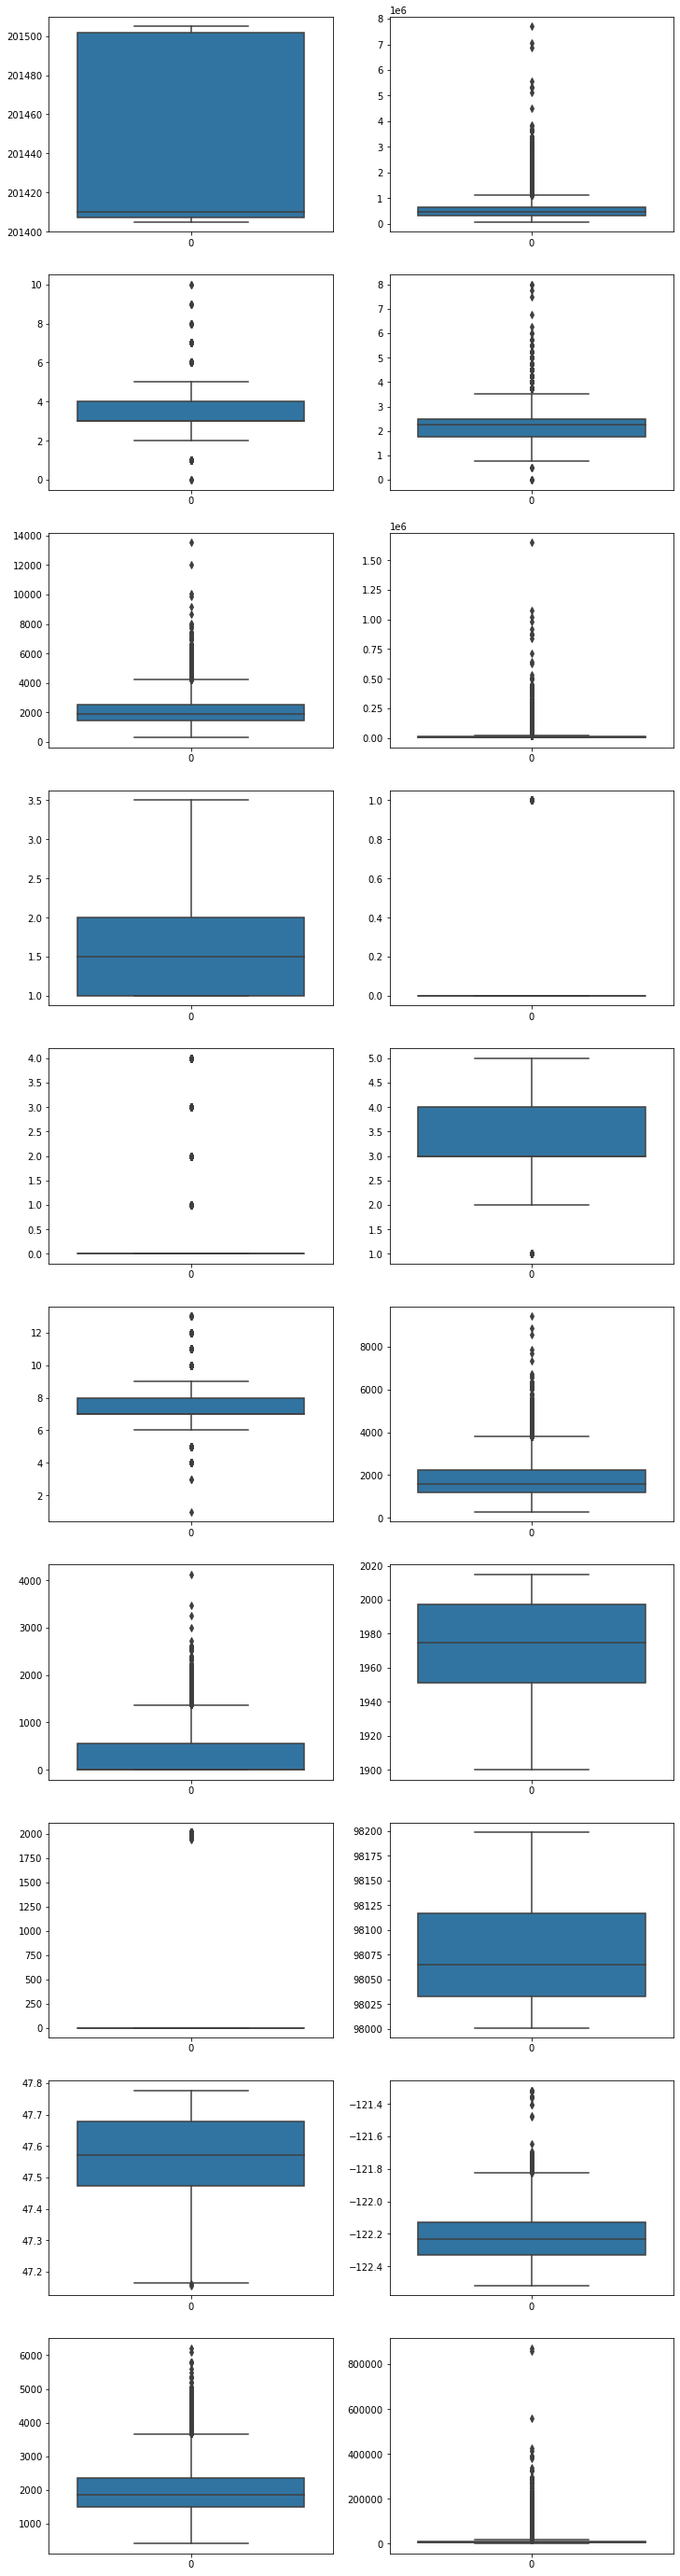

In [10]:
fig, ax = plt.subplots(10, 2, figsize=(12,50))

count = 1

for row in range(10):
    for col in range(2):
        sns.boxplot(data = train[columns[count]], ax=ax[row][col])
        count += 1
        if count == 19:
            break

In [11]:
train.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

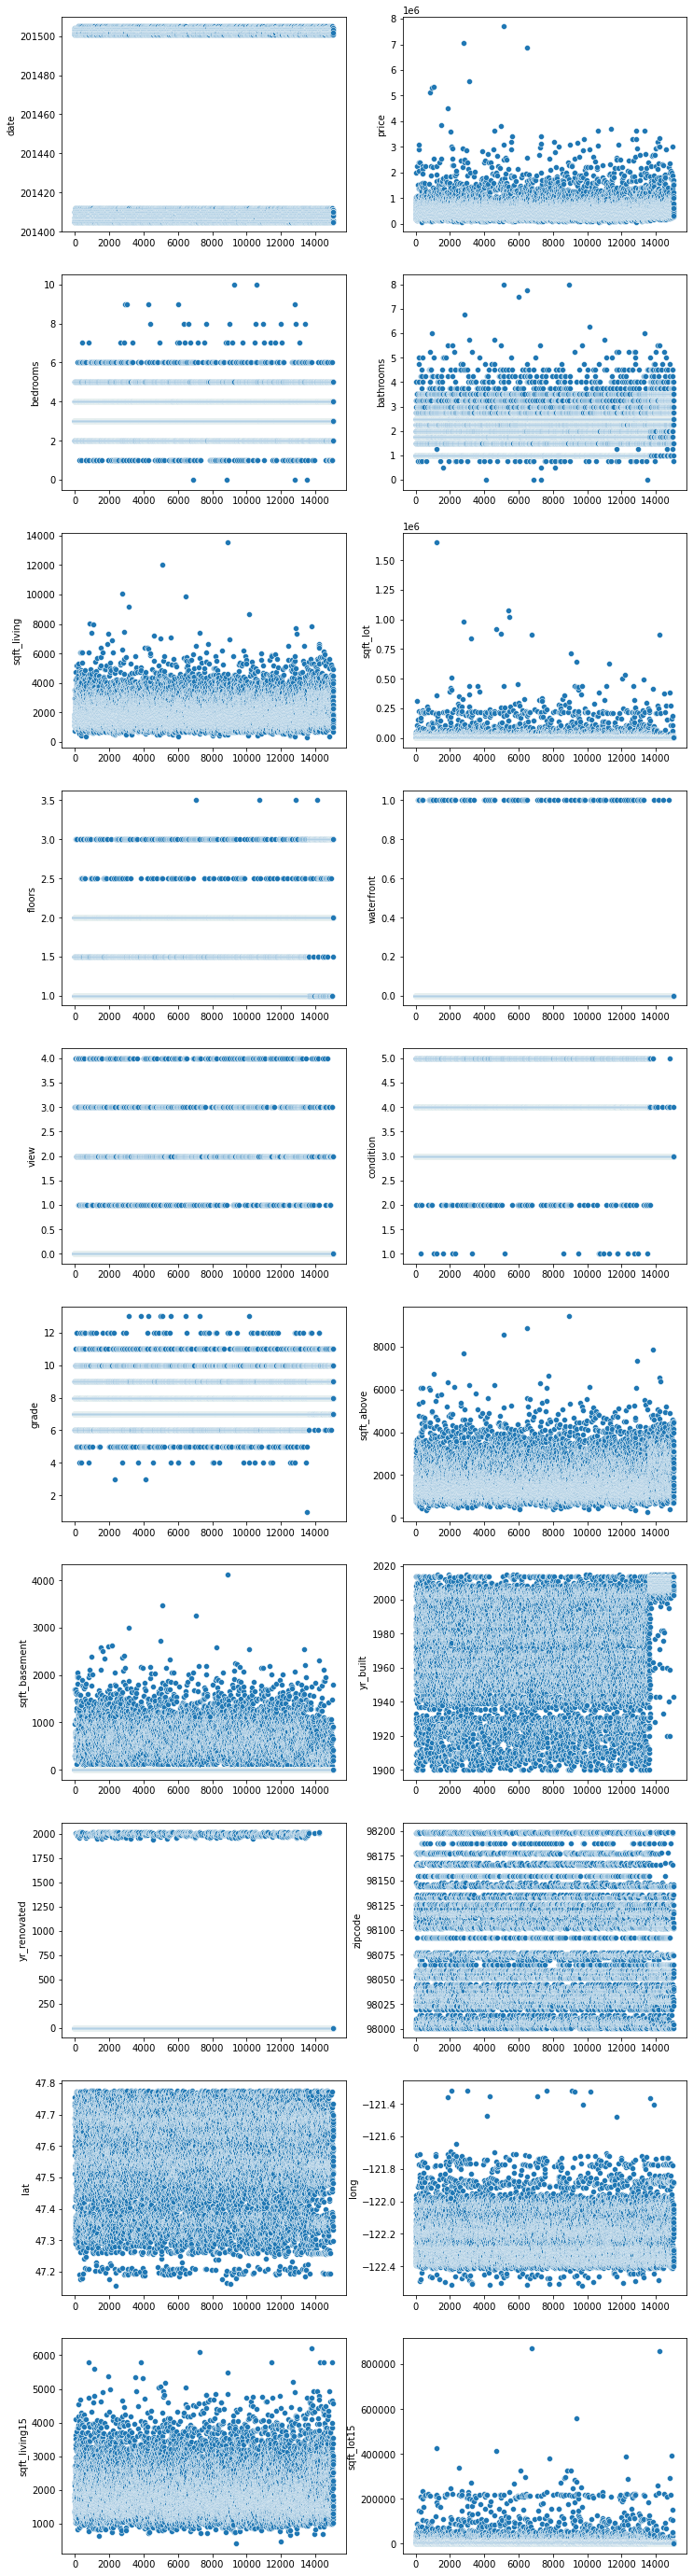

In [12]:
fig, ax = plt.subplots(10, 2, figsize=(12,50))

count = 1

for row in range(10):
    for col in range(2):
        sns.scatterplot(data = train[columns[count]], ax=ax[row][col])
        count += 1
        if count == 19:
            break

In [13]:
print(len(train[train['yr_renovated']==0]))

14404


In [14]:
print(len(train) - len(train[train['yr_renovated']==0]))

631


In [15]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
train.corr()[train.corr() > 0.8]

id  date  price  bedrooms  bathrooms  sqft_living  sqft_lot  \
id             1.0   NaN    NaN       NaN        NaN          NaN       NaN   
date           NaN   1.0    NaN       NaN        NaN          NaN       NaN   
price          NaN   NaN    1.0       NaN        NaN          NaN       NaN   
bedrooms       NaN   NaN    NaN       1.0        NaN          NaN       NaN   
bathrooms      NaN   NaN    NaN       NaN        1.0          NaN       NaN   
sqft_living    NaN   NaN    NaN       NaN        NaN     1.000000       NaN   
sqft_lot       NaN   NaN    NaN       NaN        NaN          NaN       1.0   
floors         NaN   NaN    NaN       NaN        NaN          NaN       NaN   
waterfront     NaN   NaN    NaN       NaN        NaN          NaN       NaN   
view           NaN   NaN    NaN       NaN        NaN          NaN       NaN   
condition      NaN   NaN    NaN       NaN        NaN          NaN       NaN   
grade          NaN   NaN    NaN       NaN        NaN          NaN       NaN   
sqft_above     NaN   NaN    NaN       NaN        NaN     0.878736       NaN   
sqft_basement  NaN   NaN    NaN       NaN        NaN          NaN       NaN   
yr_built       NaN   NaN    NaN       NaN        NaN          NaN       NaN   
yr_renovated   NaN   NaN    NaN       NaN        NaN          NaN       NaN   
zipcode        NaN   NaN    NaN       NaN        NaN          NaN       NaN   
lat            NaN   NaN    NaN       NaN        NaN          NaN       NaN   
long           NaN   NaN    NaN       NaN        NaN          NaN       NaN   
sqft_living15  NaN   NaN    NaN       NaN        NaN          NaN       NaN   
sqft_lot15     NaN   NaN    NaN       NaN        NaN          NaN       NaN   

               floors  waterfront  view  condition  grade  sqft_above  \
id                NaN         NaN   NaN        NaN    NaN         NaN   
date              NaN         NaN   NaN        NaN    NaN         NaN   
price             NaN         NaN   NaN        NaN    NaN         NaN   
bedrooms          NaN         NaN   NaN        NaN    NaN         NaN   
bathrooms         NaN         NaN   NaN        NaN    NaN         NaN   
sqft_living       NaN         NaN   NaN        NaN    NaN    0.878736   
sqft_lot          NaN         NaN   NaN        NaN    NaN         NaN   
floors            1.0         NaN   NaN        NaN    NaN         NaN   
waterfront        NaN         1.0   NaN        NaN    NaN         NaN   
view              NaN         NaN   1.0        NaN    NaN         NaN   
condition         NaN         NaN   NaN        1.0    NaN         NaN   
grade             NaN         NaN   NaN        NaN    1.0         NaN   
sqft_above        NaN         NaN   NaN        NaN    NaN    1.000000   
sqft_basement     NaN         NaN   NaN        NaN    NaN         NaN   
yr_built          NaN         NaN   NaN        NaN    NaN         NaN   
yr_renovated      NaN         NaN   NaN        NaN    NaN         NaN   
zipcode           NaN         NaN   NaN        NaN    NaN         NaN   
lat               NaN         NaN   NaN        NaN    NaN         NaN   
long              NaN         NaN   NaN        NaN    NaN         NaN   
sqft_living15     NaN         NaN   NaN        NaN    NaN         NaN   
sqft_lot15        NaN         NaN   NaN        NaN    NaN         NaN   

               sqft_basement  yr_built  yr_renovated  zipcode  lat  long  \
id                       NaN       NaN           NaN      NaN  NaN   NaN   
date                     NaN       NaN           NaN      NaN  NaN   NaN   
price                    NaN       NaN           NaN      NaN  NaN   NaN   
bedrooms                 NaN       NaN           NaN      NaN  NaN   NaN   
bathrooms                NaN       NaN           NaN      NaN  NaN   NaN   
sqft_living              NaN       NaN           NaN      NaN  NaN   NaN   
sqft_lot                 NaN       NaN           NaN      NaN  NaN   NaN   
floors                   NaN       NaN           NaN      NaN 

- yr_renovated: 집을 재건축한 년도인데 재건축을 안했으면 0로 나오는 것 같음. 회귀분석으로 채우는것을 고려할 수 있음. 하지만 결과가 왜곡 될 가능성이 있어 건들이지 않음
- condition, grade, waterfront, floors, bedrooms, bathrooms는 양자화 되어 있음
- 이 중 대소관계가 있는 변수 빼고 one_hot_encoding으로 처리하는 게 좋을 것 같음
- sqft_above와 sqft_living은 다중공진성 관계가 의심됨으로 둘 중 하나 제거
- outlier들이 보이긴 하지만 이건 양자화 된 값들을 확인할 필요도 있고 사용하면 안되는 변수도 있어서 신중히 고려
- 'price', 'sqft_above', 'sqft_basement', sqft_living', 'sqft_lot','sqft_living15', 'sqft_lot15' 은 로그 변환이 필요해 보임. 로그 변환 이후 어떻게 표현되는지 확인 필요함.
- 'bathroom'은 양자화 되어있고 변환하면 결과가 왜곡될 수 도 있다고 생각해서 변환하지 않음
- zipcode에 따른 가격 변동이 있을지 확인해봐야 함. (있다면 처리 방식이 달라짐)
- bathrooms같은경우 소숫점이 있음. 샤워실과 욕조가 빠지면 0.5, 욕조만 빠지면 0.75, 전부 있으면 1로 취급합니다.
- 다락방은 0.5개의 방으로 취급합니다.

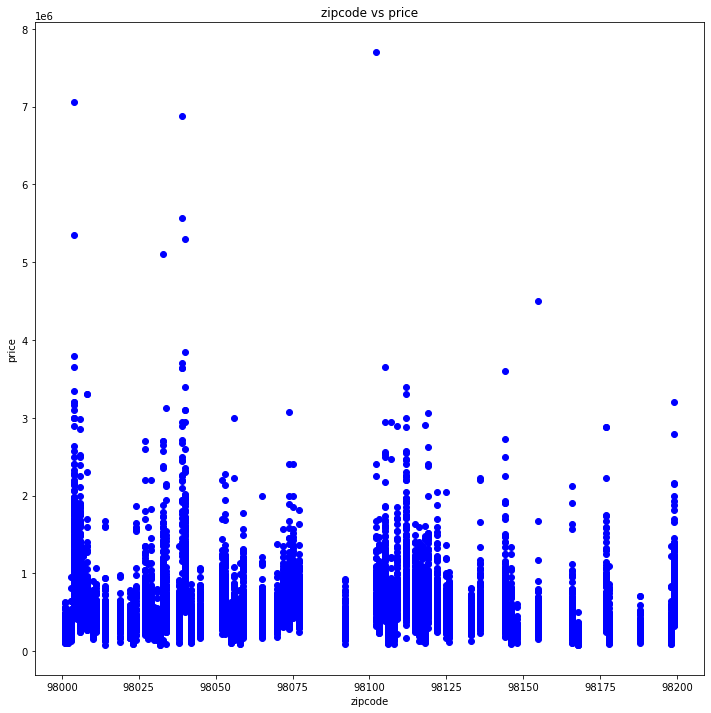

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))

ax.scatter(train['zipcode'], train['price'], color='blue')
ax.set_xlabel('zipcode')
ax.set_ylabel('price')
ax.set_title('zipcode vs price')
plt.show()

<>:11: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:11: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-17-756201a03f7a>:11: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if col is not 'price':


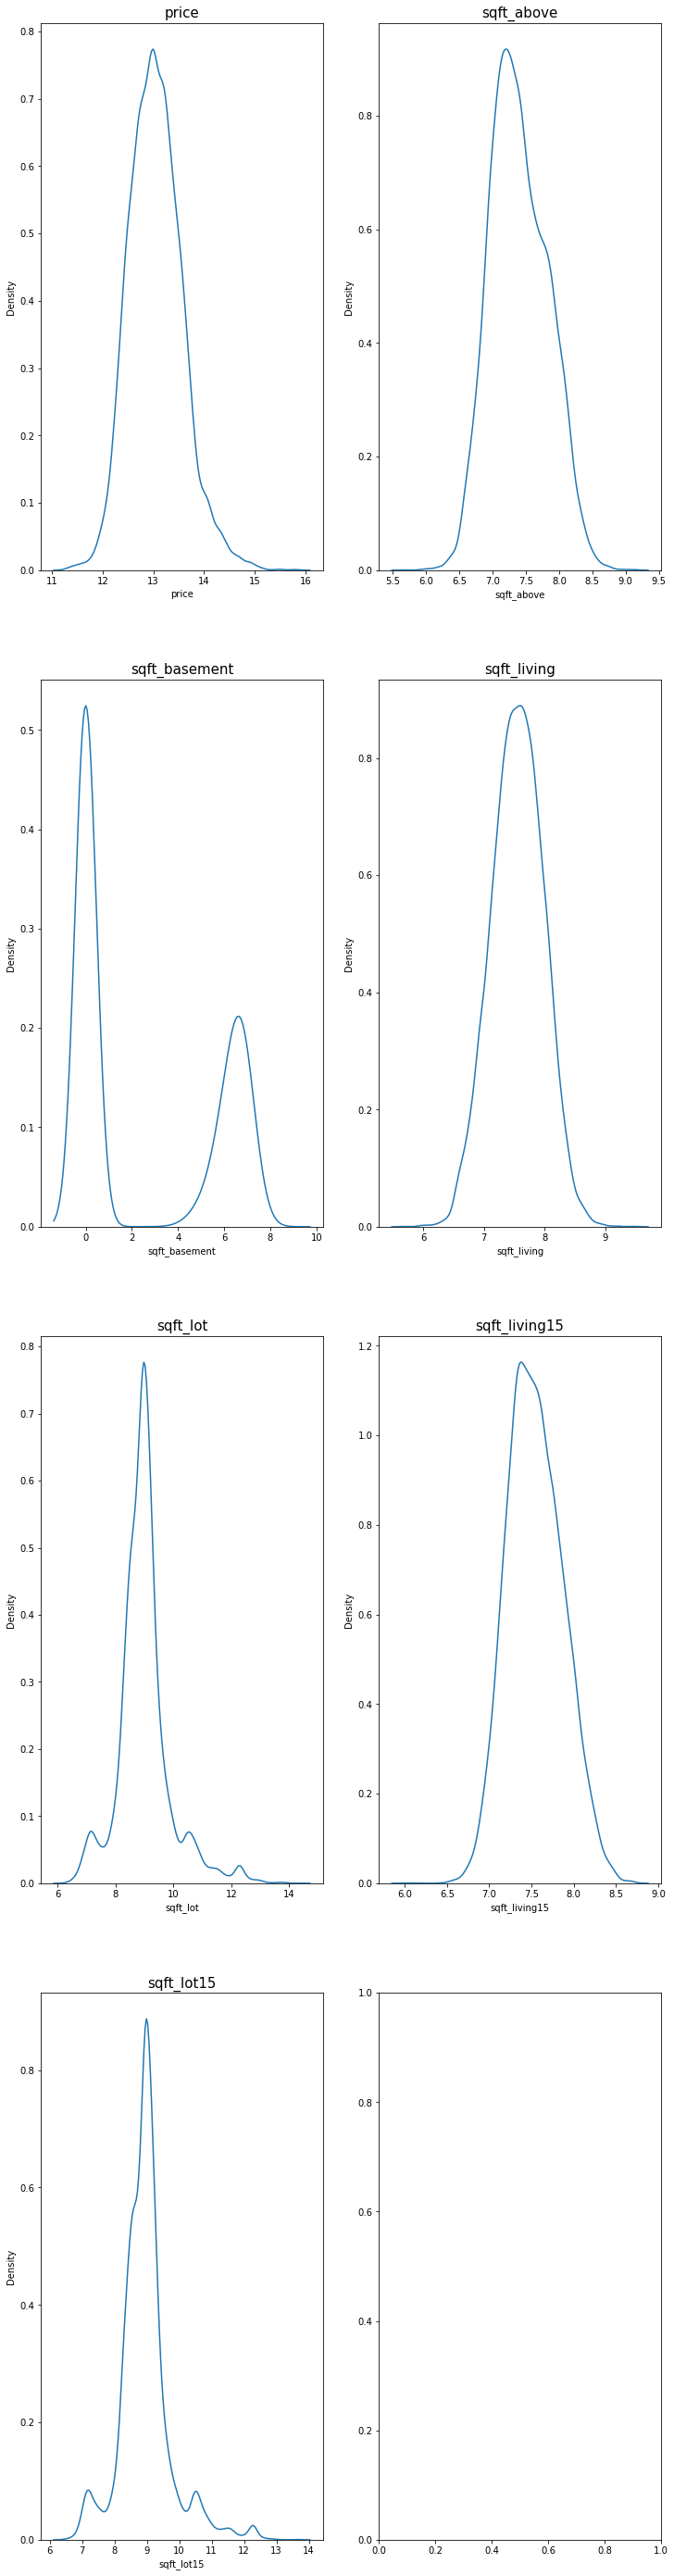

In [17]:
fig, ax = plt.subplots(4, 2, figsize=(12,50))

count = 0

log_columns = ['price','sqft_above','sqft_basement','sqft_living','sqft_lot','sqft_living15','sqft_lot15']
train_log = train
test_log = test

for col in log_columns:
    train_log[col] = np.log1p(train_log[col].values)
    if col is not 'price':
        test_log[col] = np.log1p(test_log[col].values)

for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data = train_log[log_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(log_columns[count], fontsize=15)
        count += 1

특정 범위의 zipcode에서 가격이 낮은것을 확인함.

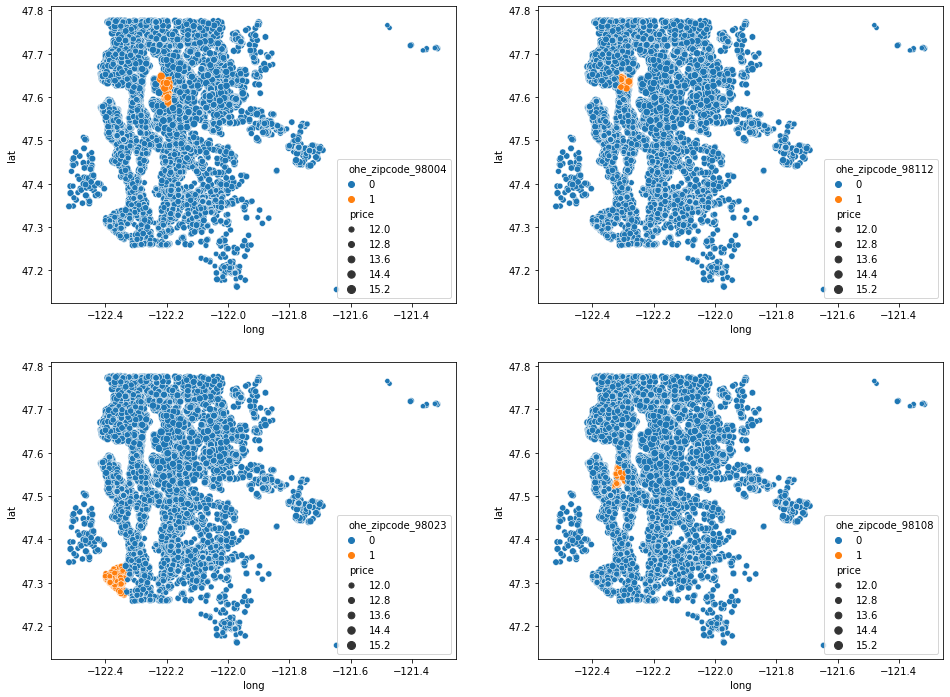

In [18]:
df = pd.get_dummies(train, columns = ['zipcode'], prefix='ohe_zipcode')
df['price'] = train['price']

fig = plt.figure(figsize = (16, 12))

ax1 = plt.subplot(221)
sns.scatterplot(x='long', y='lat', hue='ohe_zipcode_98004', size='price', data=df, ax=ax1)

ax2 = plt.subplot(222)
sns.scatterplot(x='long', y='lat', hue='ohe_zipcode_98112', size='price', data=df, ax=ax2)

ax3 = plt.subplot(223)
sns.scatterplot(x='long', y='lat', hue='ohe_zipcode_98023', size='price', data=df, ax=ax3)

ax4 = plt.subplot(224)
sns.scatterplot(x='long', y='lat', hue='ohe_zipcode_98108', size='price', data=df, ax=ax4)

plt.show()


데이터를 보면 앞의 두자리는 98로 동일. 뒤의 세자리를 통해서 여라가지 방법으로 쪼개서 새로운 feature 만들고 확인

In [19]:
data = train.copy()
data['zipcode'] = data['zipcode'].astype(str)

data['zipcode-3'] = 'z_' + data['zipcode'].str[2:3]
data['zipcode-4'] = 'z_' + data['zipcode'].str[3:4]
data['zipcode-5'] = 'z_' + data['zipcode'].str[4:5]
data['zipcode-34'] = 'z_' + data['zipcode'].str[2:4]
data['zipcode-45'] = 'z_' + data['zipcode'].str[3:5]
data['zipcode-35'] = 'z_' + data['zipcode'].str[2:3] + data['zipcode'].str[4:5]

print(data.shape)
data.head()

(15035, 27)


id    date      price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0   0  201410  12.309987         3       1.00     7.074117  8.639588     1.0   
1   1  201502  12.100718         2       1.00     6.647688  9.210440     1.0   
2   2  201502  13.142168         3       2.00     7.427144  8.997271     1.0   
3   3  201406  12.458779         3       2.25     7.447751  8.827615     2.0   
4   4  201501  12.583999         3       1.50     6.966967  9.181118     1.0   

   waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  \
0           0     0          3      7    7.074117            0.0      1955   
1           0     0          3      6    6.647688            0.0      1933   
2           0     0          3      8    7.427144            0.0      1987   
3           0     0          3      7    7.447751            0.0      1995   
4           0     0          3      7    6.966967            0.0      1963   

   yr_renovated zipcode      lat     long  sqft_living15  sqft_lot15  \
0             0   98178  47.5112 -122.257       7.201171    8.639588   
1             0   98028  47.7379 -122.233       7.908755    8.995041   
2             0   98074  47.6168 -122.045       7.496097    8.923191   
3             0   98003  47.3097 -122.327       7.713785    8.827615   
4             0   98198  47.4095 -122.315       7.409136    9.181118   

  zipcode-3 zipcode-4 zipcode-5 zipcode-34 zipcode-45 zipcode-35  
0       z_1       z_7       z_8       z_17       z_78       z_18  
1       z_0       z_2       z_8       z_02       z_28       z_08  
2       z_0       z_7       z_4       z_07       z_74       z_04  
3       z_0       z_0       z_3       z_00       z_03       z_03  
4       z_1       z_9       z_8       z_19       z_98       z_18

<AxesSubplot:xlabel='long', ylabel='lat'>

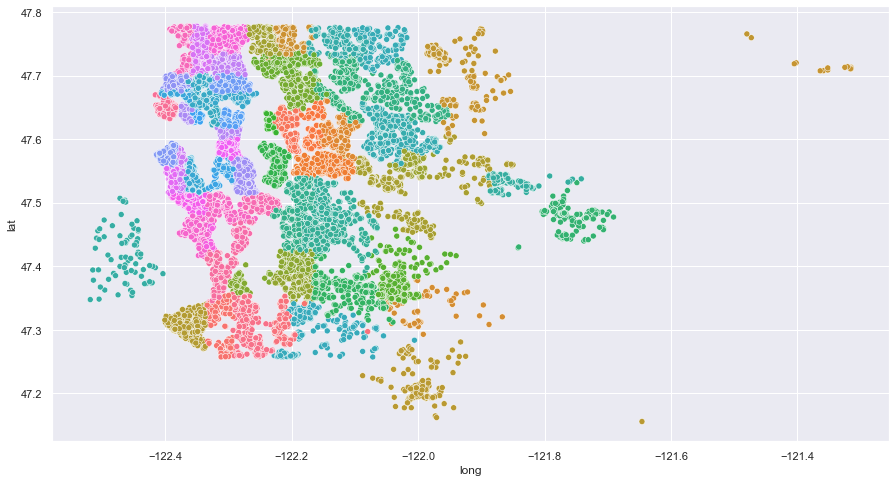

In [20]:
data['zipcode'] = 'z_' + data['zipcode']
sns.set(rc={"figure.figsize": (15, 8)})
sns.scatterplot(x='long', y='lat', hue='zipcode', hue_order=np.sort(data['zipcode'].unique()), data=data, legend=False)

새롭게 전처리된 feature로 scatterplot 찍어보기

<AxesSubplot:xlabel='long', ylabel='lat'>

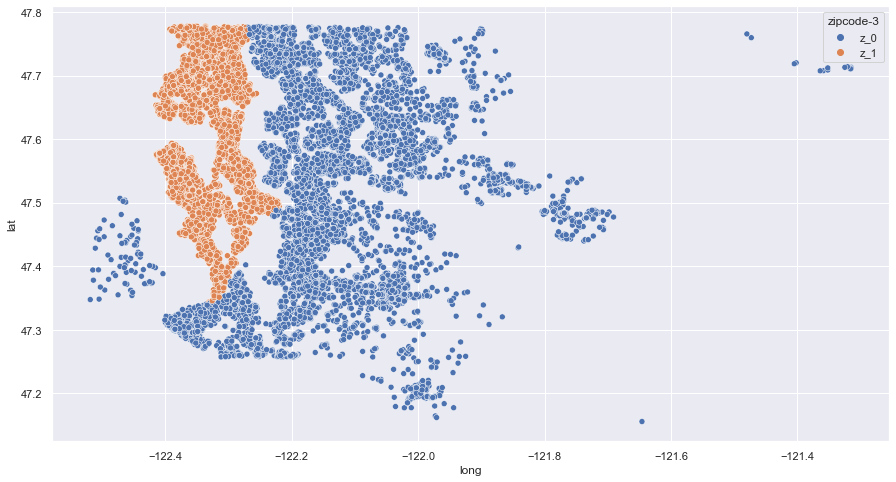

In [21]:
sns.scatterplot(x='long', y='lat', hue='zipcode-3', hue_order=np.sort(data['zipcode-3'].unique()), data=data)

<AxesSubplot:xlabel='long', ylabel='lat'>

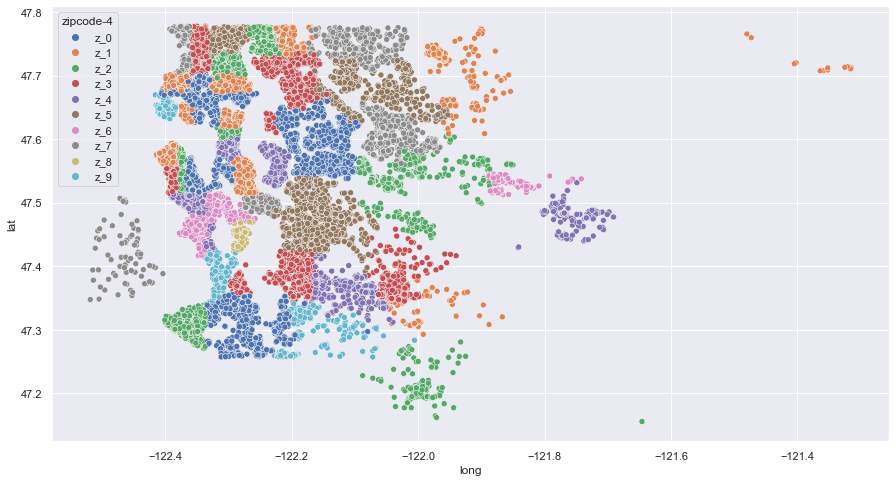

In [22]:
sns.scatterplot(x='long', y='lat', hue='zipcode-4', hue_order=np.sort(data['zipcode-4'].unique()), data=data)

<AxesSubplot:xlabel='long', ylabel='lat'>

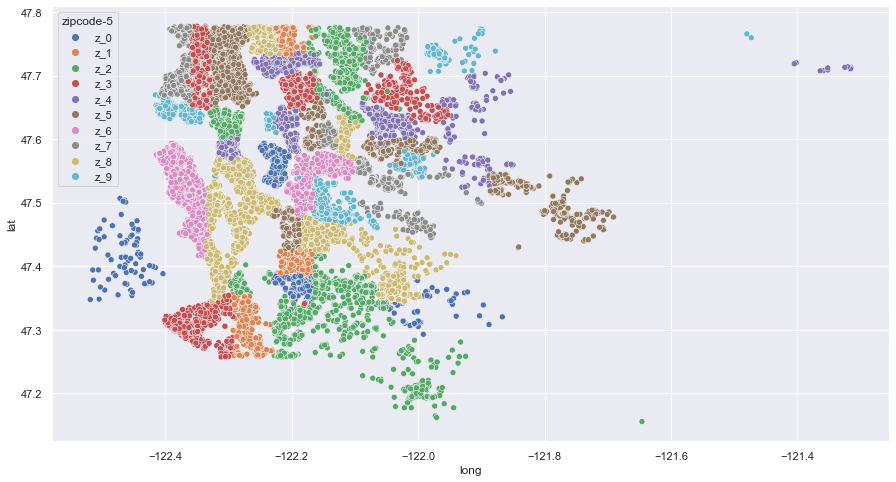

In [23]:
sns.scatterplot(x='long', y='lat', hue='zipcode-5', hue_order=np.sort(data['zipcode-5'].unique()), data=data)

<AxesSubplot:xlabel='long', ylabel='lat'>

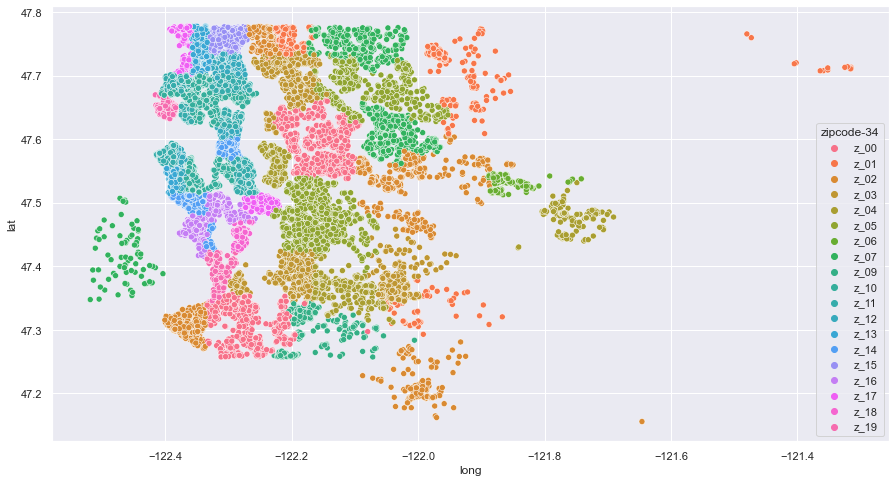

In [24]:
sns.scatterplot(x='long', y='lat', hue='zipcode-34', hue_order=np.sort(data['zipcode-34'].unique()), data=data)

<AxesSubplot:xlabel='long', ylabel='lat'>

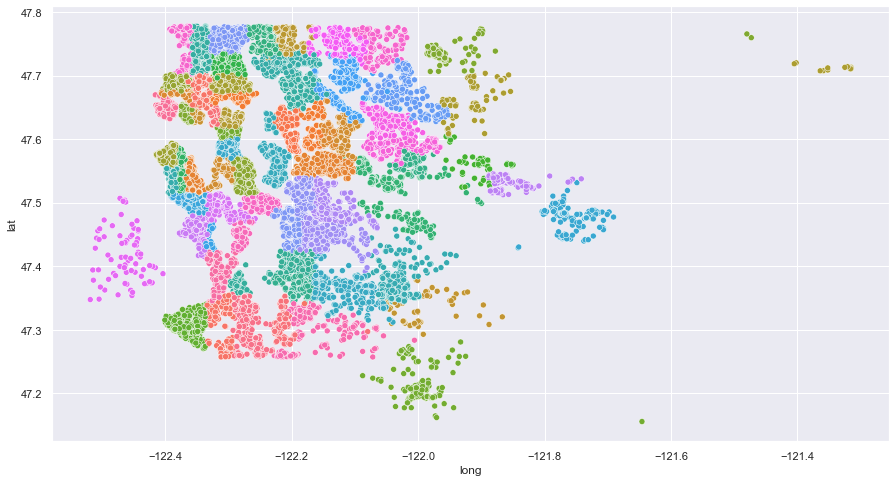

In [25]:
sns.scatterplot(x='long', y='lat', hue='zipcode-45', hue_order=np.sort(data['zipcode-45'].unique()), data=data, legend=False)

<AxesSubplot:xlabel='long', ylabel='lat'>

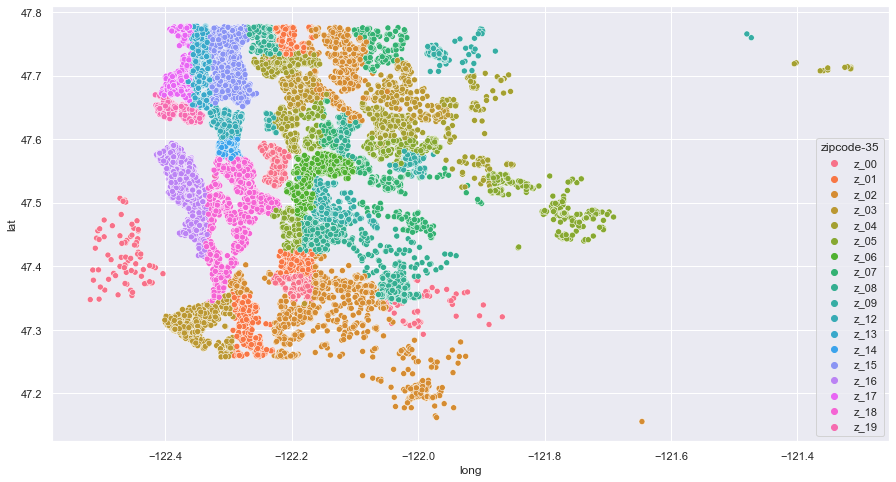

In [26]:
sns.scatterplot(x='long', y='lat', hue='zipcode-35', hue_order=np.sort(data['zipcode-35'].unique()), data=data)

## 3. 전처리

outlier 확인을 위햇 다시한번 boxplot을 그려봄

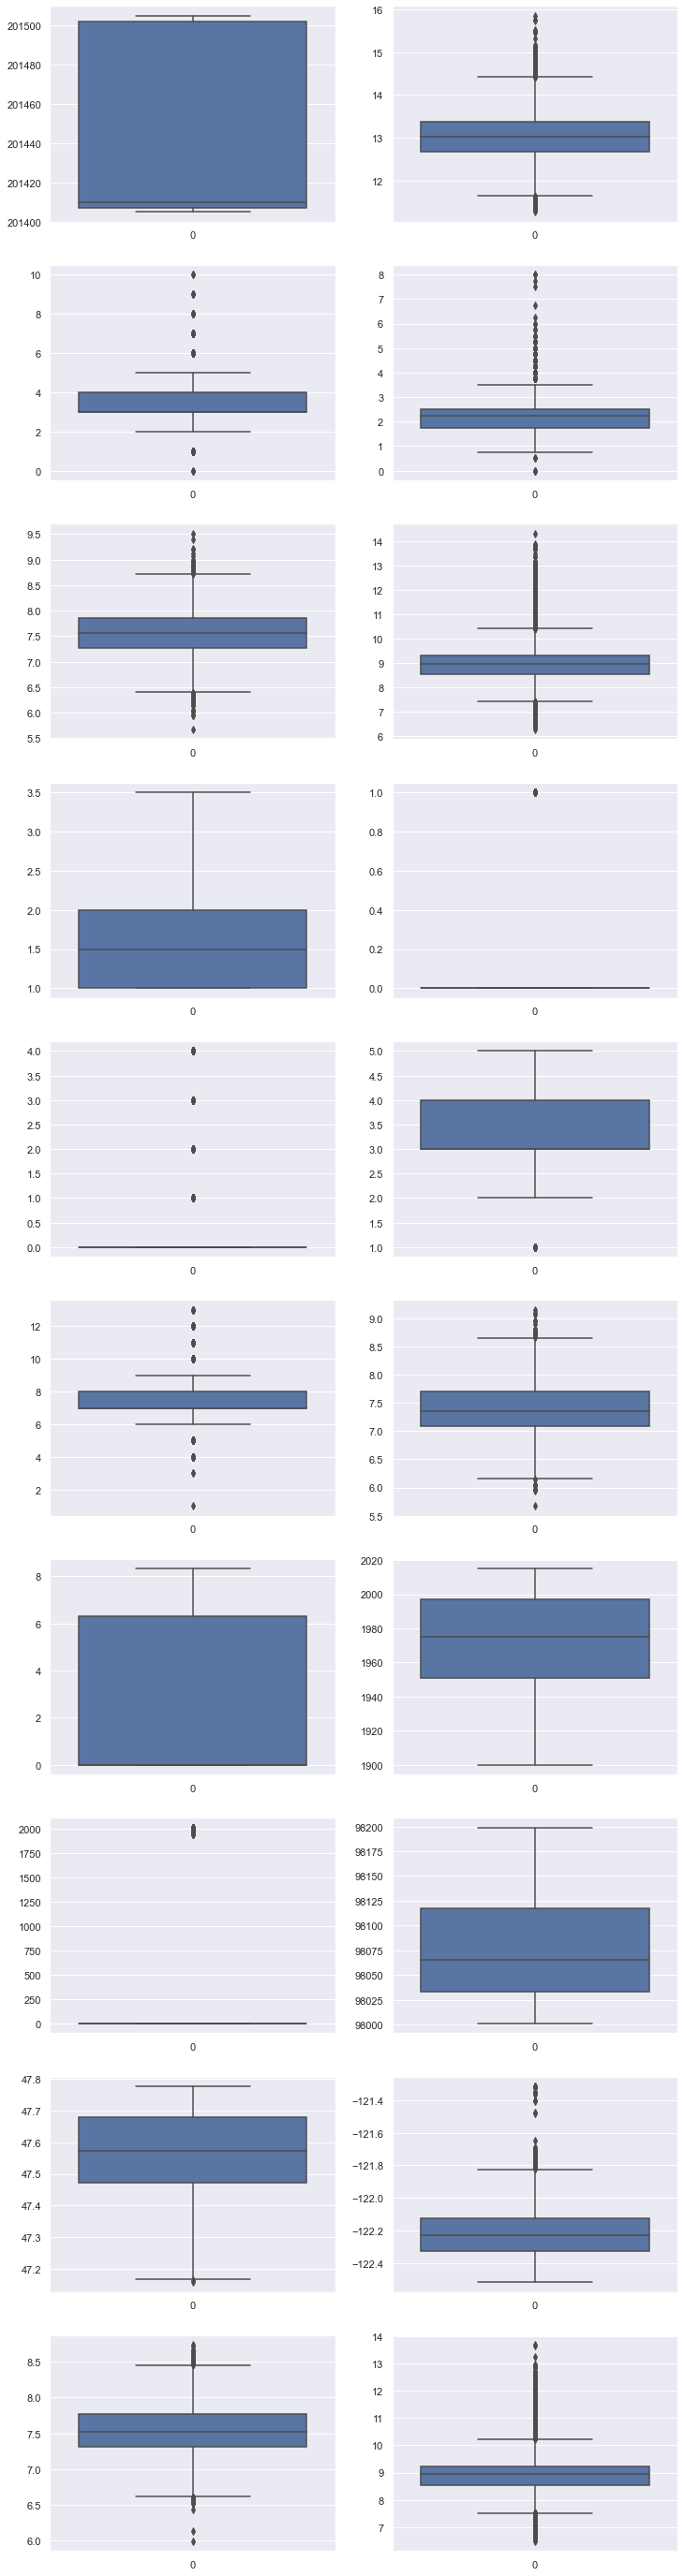

In [27]:
fig, ax = plt.subplots(10, 2, figsize=(12,50))

count = 1

for row in range(10):
    for col in range(2):
        sns.boxplot(data = train_log[columns[count]], ax=ax[row][col])
        count += 1
        if count == 19:
            break

zipcode를 활용한 방법이 있어서 같은 방법으로 이를 활용해 보기로 함

In [28]:
train_log['zipcode'] = train_log['zipcode'].astype(str)

train_log['zipcode-3'] = train_log['zipcode'].str[2:3].astype(int)
train_log['zipcode-4'] = train_log['zipcode'].str[3:4].astype(int)
train_log['zipcode-5'] = train_log['zipcode'].str[4:5].astype(int)
train_log['zipcode-34'] = train_log['zipcode'].str[2:4].astype(int)
train_log['zipcode-45'] = train_log['zipcode'].str[3:5].astype(int)
train_log['zipcode-35'] = (train_log['zipcode'].str[2:3] + train_log['zipcode'].str[4:5]).astype(int)

test_log['zipcode'] = test_log['zipcode'].astype(str)

test_log['zipcode-3'] = test_log['zipcode'].str[2:3].astype(int)
test_log['zipcode-4'] = test_log['zipcode'].str[3:4].astype(int)
test_log['zipcode-5'] = test_log['zipcode'].str[4:5].astype(int)
test_log['zipcode-34'] = test_log['zipcode'].str[2:4].astype(int)
test_log['zipcode-45'] = test_log['zipcode'].str[3:5].astype(int)
test_log['zipcode-35'] = (test_log['zipcode'].str[2:3] + test_log['zipcode'].str[4:5]).astype(int)

print(train_log.shape)
train_log.head()

(15035, 27)


id    date      price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0   0  201410  12.309987         3       1.00     7.074117  8.639588     1.0   
1   1  201502  12.100718         2       1.00     6.647688  9.210440     1.0   
2   2  201502  13.142168         3       2.00     7.427144  8.997271     1.0   
3   3  201406  12.458779         3       2.25     7.447751  8.827615     2.0   
4   4  201501  12.583999         3       1.50     6.966967  9.181118     1.0   

   waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  \
0           0     0          3      7    7.074117            0.0      1955   
1           0     0          3      6    6.647688            0.0      1933   
2           0     0          3      8    7.427144            0.0      1987   
3           0     0          3      7    7.447751            0.0      1995   
4           0     0          3      7    6.966967            0.0      1963   

   yr_renovated zipcode      lat     long  sqft_living15  sqft_lot15  \
0             0   98178  47.5112 -122.257       7.201171    8.639588   
1             0   98028  47.7379 -122.233       7.908755    8.995041   
2             0   98074  47.6168 -122.045       7.496097    8.923191   
3             0   98003  47.3097 -122.327       7.713785    8.827615   
4             0   98198  47.4095 -122.315       7.409136    9.181118   

   zipcode-3  zipcode-4  zipcode-5  zipcode-34  zipcode-45  zipcode-35  
0          1          7          8          17          78          18  
1          0          2          8           2          28           8  
2          0          7          4           7          74           4  
3          0          0          3           0           3           3  
4          1          9          8          19          98          18

In [29]:
# pca for lat, long
coord = train_log[['lat','long']]
coord_test = test_log[['lat','long']]
pca = PCA(n_components=2)
pca.fit(coord)

coord_pca = pca.transform(coord)
coord_pca_test =  pca.transform(coord_test)

train_log['coord_pca1'] = coord_pca[:, 0]
train_log['coord_pca2'] = coord_pca[:, 1]
test_log['coord_pca1'] = coord_pca_test[:, 0]
test_log['coord_pca2'] = coord_pca_test[:, 1]

이상치 재거. 이상치를 재거한 데이터를 확인 후 도입. 단, 양자화 된 변수는 건들지 않음

In [30]:
def Outliers(x, cols = None):
    if cols is None:
        cols = x.columns
    for col in cols:
        Q1 = x[col].quantile(0.25)
        Q3 = x[col].quantile(0.75)
        IQR = Q3 - Q1

        x = x[(x[col] > Q1 - 1.5*IQR) | (x[col] < Q3 + 1.5*IQR)]
    return x

features_outlier = ['sqft_living','sqft_lot', 'sqft_basement', 'sqft_living15', 'sqft_lot15']

train_outlier = Outliers(train_log, cols = features_outlier)
train_outlier.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15035 entries, 0 to 15034
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  int32  
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  float64
 6   sqft_lot       15035 non-null  float64
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  float64
 13  sqft_basement  15035 non-null  float64
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  object 
 17  lat            15035 non-null  float64
 18  long  

이상치 제거로 제거된 데이터 없음.

bathroom이 없는 경우는 이상치로 판단(주거 공간이 아님)

In [31]:
print(train_outlier[train_outlier['bathrooms']==0])

          id    date      price  bedrooms  bathrooms  sqft_living   sqft_lot  \
4123    4123  201411  12.542548         1        0.0     6.398595  10.106510   
6885    6885  201412  12.367345         0        0.0     7.293698   8.476580   
7322    7322  201409  13.089842         1        0.0     6.538140  10.053845   
13522  13522  201409  11.863589         0        0.0     5.673323   9.946355   

       floors  waterfront  view  condition  grade  sqft_above  sqft_basement  \
4123      1.0           0     0          2      3    6.398595            0.0   
6885      2.0           0     0          3      7    7.293698            0.0   
7322      1.0           0     0          4      7    6.538140            0.0   
13522     1.0           0     0          1      1    5.673323            0.0   

       yr_built  yr_renovated zipcode      lat     long  sqft_living15  \
4123       1950             0   98045  47.5316 -121.749       6.898715   
6885       1996             0   98065  47.5265 -12

In [32]:
train_outlier =  train_outlier[train_outlier['bathrooms']!=0]

In [33]:
train_outlier.head()

id    date      price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0   0  201410  12.309987         3       1.00     7.074117  8.639588     1.0   
1   1  201502  12.100718         2       1.00     6.647688  9.210440     1.0   
2   2  201502  13.142168         3       2.00     7.427144  8.997271     1.0   
3   3  201406  12.458779         3       2.25     7.447751  8.827615     2.0   
4   4  201501  12.583999         3       1.50     6.966967  9.181118     1.0   

   waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  \
0           0     0          3      7    7.074117            0.0      1955   
1           0     0          3      6    6.647688            0.0      1933   
2           0     0          3      8    7.427144            0.0      1987   
3           0     0          3      7    7.447751            0.0      1995   
4           0     0          3      7    6.966967            0.0      1963   

   yr_renovated zipcode      lat     long  sqft_living15  sqft_lot15  \
0             0   98178  47.5112 -122.257       7.201171    8.639588   
1             0   98028  47.7379 -122.233       7.908755    8.995041   
2             0   98074  47.6168 -122.045       7.496097    8.923191   
3             0   98003  47.3097 -122.327       7.713785    8.827615   
4             0   98198  47.4095 -122.315       7.409136    9.181118   

   zipcode-3  zipcode-4  zipcode-5  zipcode-34  zipcode-45  zipcode-35  \
0          1          7          8          17          78          18   
1          0          2          8           2          28           8   
2          0          7          4           7          74           4   
3          0          0          3           0           3           3   
4          1          9          8          19          98          18   

   coord_pca1  coord_pca2  
0   -0.001086   -0.065788  
1   -0.129196    0.122778  
2    0.092545    0.151764  
3    0.075629   -0.264828  
4    0.020327   -0.180889

In [34]:
train_outlier[train_outlier['bathrooms']==0].head()

Empty DataFrame
Columns: [id, date, price, bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterfront, view, condition, grade, sqft_above, sqft_basement, yr_built, yr_renovated, zipcode, lat, long, sqft_living15, sqft_lot15, zipcode-3, zipcode-4, zipcode-5, zipcode-34, zipcode-45, zipcode-35, coord_pca1, coord_pca2]
Index: []

waterfront는 one hot encoding

In [35]:
train_outlier = pd.get_dummies(train_outlier, columns = ['waterfront'])
test_log = pd.get_dummies(test_log, columns = ['waterfront'])

In [36]:
train_outlier[train_outlier['yr_renovated']!=0].head()

id    date      price  bedrooms  bathrooms  sqft_living   sqft_lot  \
26    26  201406  13.453106         3       2.50     7.741099   8.026497   
78    78  201411  13.515082         3       3.50     8.385032   8.756368   
149  149  201502  14.224304         5       3.00     8.101981  10.418554   
160  160  201504  13.392392         2       1.75     7.280008   9.667702   
166  166  201503  12.923915         4       1.00     7.586296   8.464003   

     floors  view  condition  grade  sqft_above  sqft_basement  yr_built  \
26      1.5     0          3      8    7.320527       6.673298      1930   
78      2.0     0          3      8    7.930566       7.378384      1900   
149     1.0     3          3      9    7.534228       7.266129      1957   
160     2.0     4          3      7    7.115582       5.398163      1915   
166     1.5     0          3      7    7.421178       5.707110      1904   

     yr_renovated zipcode      lat     long  sqft_living15  sqft_lot15  \
26           2002   98115  47.6827 -122.310       7.372118    8.091015   
78           1999   98117  47.6981 -122.368       7.512618    8.756368   
149          1991   98040  47.5673 -122.210       8.252446    9.950085   
160          1978   98166  47.4497 -122.375       7.616284    9.487517   
166          2005   98122  47.6136 -122.303       7.320527    8.464003   

     zipcode-3  zipcode-4  zipcode-5  zipcode-34  zipcode-45  zipcode-35  \
26           1          1          5          11          15          15   
78           1          1          7          11          17          17   
149          0          4          0           4          40           0   
160          1          6          6          16          66          16   
166          1          2          2          12          22          12   

     coord_pca1  coord_pca2  waterfront_0  waterfront_1  
26    -0.152323    0.030902             1             0  
78    -0.206547    0.005194             1             0  
149   -0.001443    0.007398             1             0  
160   -0.051443   -0.188956             0             1  
166   -0.102346   -0.017328             1             0

성능을 위해서 다음과 같은 feature를 추가

In [37]:
train_outlier['spot_changes'] = train_outlier['sqft_living15'] - train_outlier['sqft_living']
train_outlier['renovated_year'] = train_outlier['date'].apply(lambda x : str(x)[:4]).astype(int) - np.maximum(train_outlier['yr_renovated'], train_outlier['yr_built'])
train_outlier['total_area'] = np.maximum(train_outlier['sqft_living'],train_outlier['sqft_living15']) + train_outlier['sqft_basement']
train_outlier[train_outlier['renovated_year']!=0].head()

id    date      price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0   0  201410  12.309987         3       1.00     7.074117  8.639588     1.0   
1   1  201502  12.100718         2       1.00     6.647688  9.210440     1.0   
2   2  201502  13.142168         3       2.00     7.427144  8.997271     1.0   
3   3  201406  12.458779         3       2.25     7.447751  8.827615     2.0   
4   4  201501  12.583999         3       1.50     6.966967  9.181118     1.0   

   view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0     0          3      7    7.074117            0.0      1955             0   
1     0          3      6    6.647688            0.0      1933             0   
2     0          3      8    7.427144            0.0      1987             0   
3     0          3      7    7.447751            0.0      1995             0   
4     0          3      7    6.966967            0.0      1963             0   

  zipcode      lat     long  sqft_living15  sqft_lot15  zipcode-3  zipcode-4  \
0   98178  47.5112 -122.257       7.201171    8.639588          1          7   
1   98028  47.7379 -122.233       7.908755    8.995041          0          2   
2   98074  47.6168 -122.045       7.496097    8.923191          0          7   
3   98003  47.3097 -122.327       7.713785    8.827615          0          0   
4   98198  47.4095 -122.315       7.409136    9.181118          1          9   

   zipcode-5  zipcode-34  zipcode-45  zipcode-35  coord_pca1  coord_pca2  \
0          8          17          78          18   -0.001086   -0.065788   
1          8           2          28           8   -0.129196    0.122778   
2          4           7          74           4    0.092545    0.151764   
3          3           0           3           3    0.075629   -0.264828   
4          8          19          98          18    0.020327   -0.180889   

   waterfront_0  waterfront_1  spot_changes  renovated_year  total_area  
0             1             0      0.127054              59    7.201171  
1             1             0      1.261066              82    7.908755  
2             1             0      0.068953              28    7.496097  
3             1             0      0.266033              19    7.713785  
4             1             0      0.442169              52    7.409136

In [38]:
test_log['spot_changes'] = test_log['sqft_living15'] - test_log['sqft_living']
test_log['renovated_year'] = test_log['date'].apply(lambda x : str(x)[:4]).astype(int) - np.maximum(test_log['yr_renovated'], test_log['yr_built'])
test_log['total_area'] = np.maximum(test_log['sqft_living'],test_log['sqft_living15']) + test_log['sqft_basement']
test_log[test_log['renovated_year']!=0].head()

id    date  bedrooms  bathrooms  sqft_living   sqft_lot  floors  view  \
0  15035  201412         3       2.25     7.852050   8.887791     2.0     0   
1  15036  201412         4       3.00     7.581210   8.517393     1.0     0   
2  15037  201405         4       4.50     8.598036  11.532051     1.0     0   
3  15038  201504         3       1.00     7.484930   8.918784     1.0     0   
4  15039  201503         3       2.50     7.544861   8.788898     2.0     0   

   condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0          3      7    7.682943       5.993961      1951          1991   
1          5      7    6.957497       6.814543      1965             0   
2          3     11    8.266421       7.333676      2001             0   
3          3      7    6.957497       6.594413      1960             0   
4          3      7    7.544861       0.000000      2003             0   

  zipcode      lat     long  sqft_living15  sqft_lot15  zipcode-3  zipcode-4  \
0   98125  47.7210 -122.319       7.433075    8.941153          1          2   
1   98136  47.5208 -122.393       7.215975    8.517393          1          3   
2   98053  47.6561 -122.005       8.468213   11.532051          0          5   
3   98146  47.5123 -122.337       7.484930    9.001346          1          4   
4   98038  47.3684 -122.031       7.779467    8.932080          0          3   

   zipcode-5  zipcode-34  zipcode-45  zipcode-35  coord_pca1  coord_pca2  \
0          5          12          25          15   -0.183932    0.054327   
1          6          13          36          16   -0.111110   -0.146305   
2          3           5          53           3    0.097696    0.207602   
3          6          14          46          16   -0.062869   -0.116622   
4          8           3          38           8    0.263680   -0.028822   

   waterfront_0  waterfront_1  spot_changes  renovated_year  total_area  
0             1             0     -0.418975              23   13.846012  
1             1             0     -0.365235              49   14.395753  
2             1             0     -0.129823              13   15.931712  
3             1             0      0.000000              55   14.079344  
4             1             0      0.234606              12    7.779467

Label encoding 된 변수 이외의 continuous 한 변수를 standardization

In [39]:
CON_COL = ['sqft_living','sqft_lot', 'sqft_basement', 'coord_pca1', 'coord_pca2', 'sqft_living15', 'sqft_lot15','spot_changes','renovated_year','total_area']

scaler = StandardScaler()
train_outlier[CON_COL] = scaler.fit_transform(train_outlier[CON_COL])
test_log[CON_COL] = scaler.transform(test_log[CON_COL])

In [40]:
train_outlier.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'zipcode-3', 'zipcode-4', 'zipcode-5',
       'zipcode-34', 'zipcode-45', 'zipcode-35', 'coord_pca1', 'coord_pca2',
       'waterfront_0', 'waterfront_1', 'spot_changes', 'renovated_year',
       'total_area'],
      dtype='object')

id항목을 재거. validation을 확인하려 했으나 grid search를 할것임으로 우선순위가 낮다고 생각해서 일단은 test와 train으로만 구분하는것으로 진행

In [41]:
features = ['date', 'bedrooms', 'bathrooms', 'sqft_living',
            'sqft_lot', 'floors', 'view', 'condition', 'grade', 
            'sqft_basement', 'yr_built', 'yr_renovated','coord_pca1', 'coord_pca2',
            'sqft_living15', 'sqft_lot15', 'zipcode-3', 'zipcode-4', 'zipcode-5',
            'zipcode-34', 'zipcode-45', 'zipcode-35', 'waterfront_0', 
            'waterfront_1', 'spot_changes', 'renovated_year', 'total_area']
target = 'price'
y_train = train_outlier[target]
train_outlier = train_outlier[features]
test_log = test_log[features]

train_outlier.head()

date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  view  \
0  201410         3       1.00    -1.125341 -0.389770     1.0     0   
1  201502         2       1.00    -2.128153  0.240471     1.0     0   
2  201502         3       2.00    -0.295142  0.005124     1.0     0   
3  201406         3       2.25    -0.246682 -0.182182     2.0     0   
4  201501         3       1.50    -1.377320  0.208097     1.0     0   

   condition  grade  sqft_basement  yr_built  yr_renovated  coord_pca1  \
0          3      7      -0.796554      1955             0   -0.006807   
1          3      6      -0.796554      1933             0   -0.867574   
2          3      8      -0.796554      1987             0    0.622302   
3          3      7      -0.796554      1995             0    0.508646   
4          3      7      -0.796554      1963             0    0.137069   

   coord_pca2  sqft_living15  sqft_lot15  zipcode-3  zipcode-4  zipcode-5  \
0   -0.505978      -1.038938   -0.396137          1          7          8   
1    0.945642       1.113531    0.040776          0          2          8   
2    1.168783      -0.141772   -0.047539          0          7          4   
3   -2.038237       0.520432   -0.165020          0          0          3   
4   -1.392058      -0.406307    0.269497          1          9          8   

   zipcode-34  zipcode-45  zipcode-35  waterfront_0  waterfront_1  \
0          17          78          18             1             0   
1           2          28           8             1             0   
2           7          74           4             1             0   
3           0           3           3             1             0   
4          19          98          18             1             0   

   spot_changes  renovated_year  total_area  
0      0.484532        0.627312   -0.909071  
1      4.495229        1.423060   -0.692314  
2      0.279045       -0.445218   -0.818725  
3      0.976065       -0.756597   -0.752040  
4      1.599010        0.385128   -0.845364

In [42]:
print(train_outlier.shape)
print(y_train.shape)

(15031, 27)
(15031,)


# 모델링

일단 가장 좋은 모델을 찾는 과정을 진행합니다

In [43]:
def get_scores(models, train, y):
    df = {}

    for model in models:
        model_name = model.__class__.__name__
    
        X_train,X_test, y_train, y_test = train_test_split(train, y, random_state=random_state,
                                                           test_size=0.2)
    
        model.fit(X_train, y_train)
    
        y_pred = model.predict(X_test)
        df[model_name] = rmse(y_test, y_pred)
    
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE',ascending=False)
    return score_df

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [44]:
random_state = 2019

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state, verbosity=0)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [45]:
score_df = get_scores(models,train_outlier, y_train)
print(score_df)

                                    RMSE
GradientBoostingRegressor  151023.141959
RandomForestRegressor      141245.029832
XGBRegressor               127726.582324
LGBMRegressor              124023.442737


LGBMRegressor가 가장 좋은 성능을 보여줌으로 LGBMRegressor를 기준으로 성능 튜닝 시작

In [46]:
param_grid = {
    'learning_rate':[0.01,0.03],
    'num_iteration':[3500],
    'max_depth':[12],
    'n_estimators':[800, 1000],
    "lambda_l1": [1],
    "lambda_l2": [0,1],
    'num_leaves': [46],
    'min_child_samples': [28],
    'subsample': [0.6],
    'colsample_bytree': [0.63],
}

In [47]:
def GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    grid_model = GridSearchCV(model, param_grid=param_grid,
                             scoring='neg_mean_squared_error', cv=5,
                             verbose=verbose, n_jobs=n_jobs)
    grid_model.fit(train,y)
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    results = pd.DataFrame(params)
    results['score'] = score

    results['RMSLE'] = np.sqrt(-1*results['score'])
    results = results.sort_values('RMSLE')

    return results

In [48]:
results = GridSearch(lightgbm, train_outlier, y_train, param_grid, verbose=1, n_jobs=32)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] num_iterations is set=3500, num_iteration=3500 will be ignored. Current value: num_iterations=3500
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


In [49]:
results.head()

colsample_bytree  lambda_l1  lambda_l2  learning_rate  max_depth  \
0              0.63          1          0           0.01         12   
1              0.63          1          0           0.01         12   
4              0.63          1          1           0.01         12   
5              0.63          1          1           0.01         12   
6              0.63          1          1           0.03         12   

   min_child_samples  n_estimators  num_iteration  num_leaves  subsample  \
0                 28           800           3500          46        0.6   
1                 28          1000           3500          46        0.6   
4                 28           800           3500          46        0.6   
5                 28          1000           3500          46        0.6   
6                 28           800           3500          46        0.6   

      score     RMSLE  
0 -0.026031  0.161340  
1 -0.026031  0.161340  
4 -0.026037  0.161361  
5 -0.026037  0.161361  
6 -0.026612  0.163132

In [50]:
print(np.expm1(results['RMSLE'].head()))

0    0.175085
1    0.175085
4    0.175109
5    0.175109
6    0.177192
Name: RMSLE, dtype: float64


In [58]:
model = LGBMRegressor(colsample_bytree=0.63, lambda_l1=1,lambda_l2=1,
                      learning_rate=0.01,max_depth=12,min_child_samples=28,n_estimators=800,num_iteration=3500,
                      num_leaves=46, subsample=0.6,random_state=random_state,verbosity=0)

In [59]:
models=[model]
score_df = get_scores(models,train_outlier, y_train)
print(score_df)

[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] num_iterations is set=3500, num_iteration=3500 will be ignored. Current value: num_iterations=3500
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
                        RMSE
LGBMRegressor  114807.684212


In [60]:
def save_submission(model, train, y, test, data_dir, model_name, rmsle = None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [61]:
print(train_outlier.shape)
print(test_log.shape)

(15031, 27)
(6468, 27)


In [62]:
test_log.head()

date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  view  \
0  201412         3       2.25     0.704090 -0.115745     2.0     0   
1  201412         4       3.00     0.067167 -0.524677     1.0     0   
2  201405         4       4.50     2.458390  2.803609     1.0     0   
3  201504         3       1.00    -0.159249 -0.081528     1.0     0   
4  201503         3       2.50    -0.018313 -0.224926     2.0     0   

   condition  grade  sqft_basement  yr_built  yr_renovated  coord_pca1  \
0          3      7       1.096184      1951          1991   -1.235347   
1          5      7       1.355303      1965             0   -0.746054   
2          3     11       1.519232      2001             0    0.656913   
3          3      7       1.285791      1960             0   -0.421924   
4          3      7      -0.796554      2003             0    1.772160   

   coord_pca2  sqft_living15  sqft_lot15  zipcode-3  zipcode-4  zipcode-5  \
0    0.418690      -0.333485   -0.025462          1          2          5   
1   -1.125818      -0.993904   -0.546336          1          3          6   
2    1.598642       2.815402    3.159203          0          5          3   
3   -0.897313      -0.175743    0.048527          1          4          6   
4   -0.221411       0.720237   -0.036613          0          3          8   

   zipcode-34  zipcode-45  zipcode-35  waterfront_0  waterfront_1  \
0          12          25          15             1             0   
1          13          36          16             1             0   
2           5          53           3             1             0   
3          14          46          16             1             0   
4           3          38           8             1             0   

   spot_changes  renovated_year  total_area  
0     -1.446625       -0.618206    1.126471  
1     -1.256561        0.281335    1.294876  
2     -0.423971       -0.964183    1.765392  
3      0.035176        0.488921    1.197949  
4      0.864914       -0.998781   -0.731919

In [63]:
train_outlier.head()

date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  view  \
0  201410         3       1.00    -1.125341 -0.389770     1.0     0   
1  201502         2       1.00    -2.128153  0.240471     1.0     0   
2  201502         3       2.00    -0.295142  0.005124     1.0     0   
3  201406         3       2.25    -0.246682 -0.182182     2.0     0   
4  201501         3       1.50    -1.377320  0.208097     1.0     0   

   condition  grade  sqft_basement  yr_built  yr_renovated  coord_pca1  \
0          3      7      -0.796554      1955             0   -0.006807   
1          3      6      -0.796554      1933             0   -0.867574   
2          3      8      -0.796554      1987             0    0.622302   
3          3      7      -0.796554      1995             0    0.508646   
4          3      7      -0.796554      1963             0    0.137069   

   coord_pca2  sqft_living15  sqft_lot15  zipcode-3  zipcode-4  zipcode-5  \
0   -0.505978      -1.038938   -0.396137          1          7          8   
1    0.945642       1.113531    0.040776          0          2          8   
2    1.168783      -0.141772   -0.047539          0          7          4   
3   -2.038237       0.520432   -0.165020          0          0          3   
4   -1.392058      -0.406307    0.269497          1          9          8   

   zipcode-34  zipcode-45  zipcode-35  waterfront_0  waterfront_1  \
0          17          78          18             1             0   
1           2          28           8             1             0   
2           7          74           4             1             0   
3           0           3           3             1             0   
4          19          98          18             1             0   

   spot_changes  renovated_year  total_area  
0      0.484532        0.627312   -0.909071  
1      4.495229        1.423060   -0.692314  
2      0.279045       -0.445218   -0.818725  
3      0.976065       -0.756597   -0.752040  
4      1.599010        0.385128   -0.845364

In [64]:
save_submission(model, train_outlier, y_train, test_log, data_dir = data_dir,model_name='lgbm', rmsle= '0.161340')

[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] num_iterations is set=3500, num_iteration=3500 will be ignored. Current value: num_iterations=3500
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
C:/Users/USER/Desktop/AIFFEL/work/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.161340.csv saved!


feature engineering 너무 힘듬

여러가지 시도를 해봤으나 근처 정보가 있을 때 기록이 재일 좋아짐.

용량이 너무 크면 작동이 안되서 일단 5개의 이웃만 사용하기로 함

기회가 된다면 더 큰 이웃으로도 시도해 볼만함

거리 데이터를 활용한 값이 더 안나옴. 무언가 데이터가 더 있어야하나봄

==================================================================

이전 테스크로 복귀. PCA 방식이랑 zip code 따로 인코딩 하는 것만 가져옴

루브릭 점수 달성


**추가**

test에 standardization을 안하고 있었음;;    
코드가 너무 많다 보니 실수 한 모양

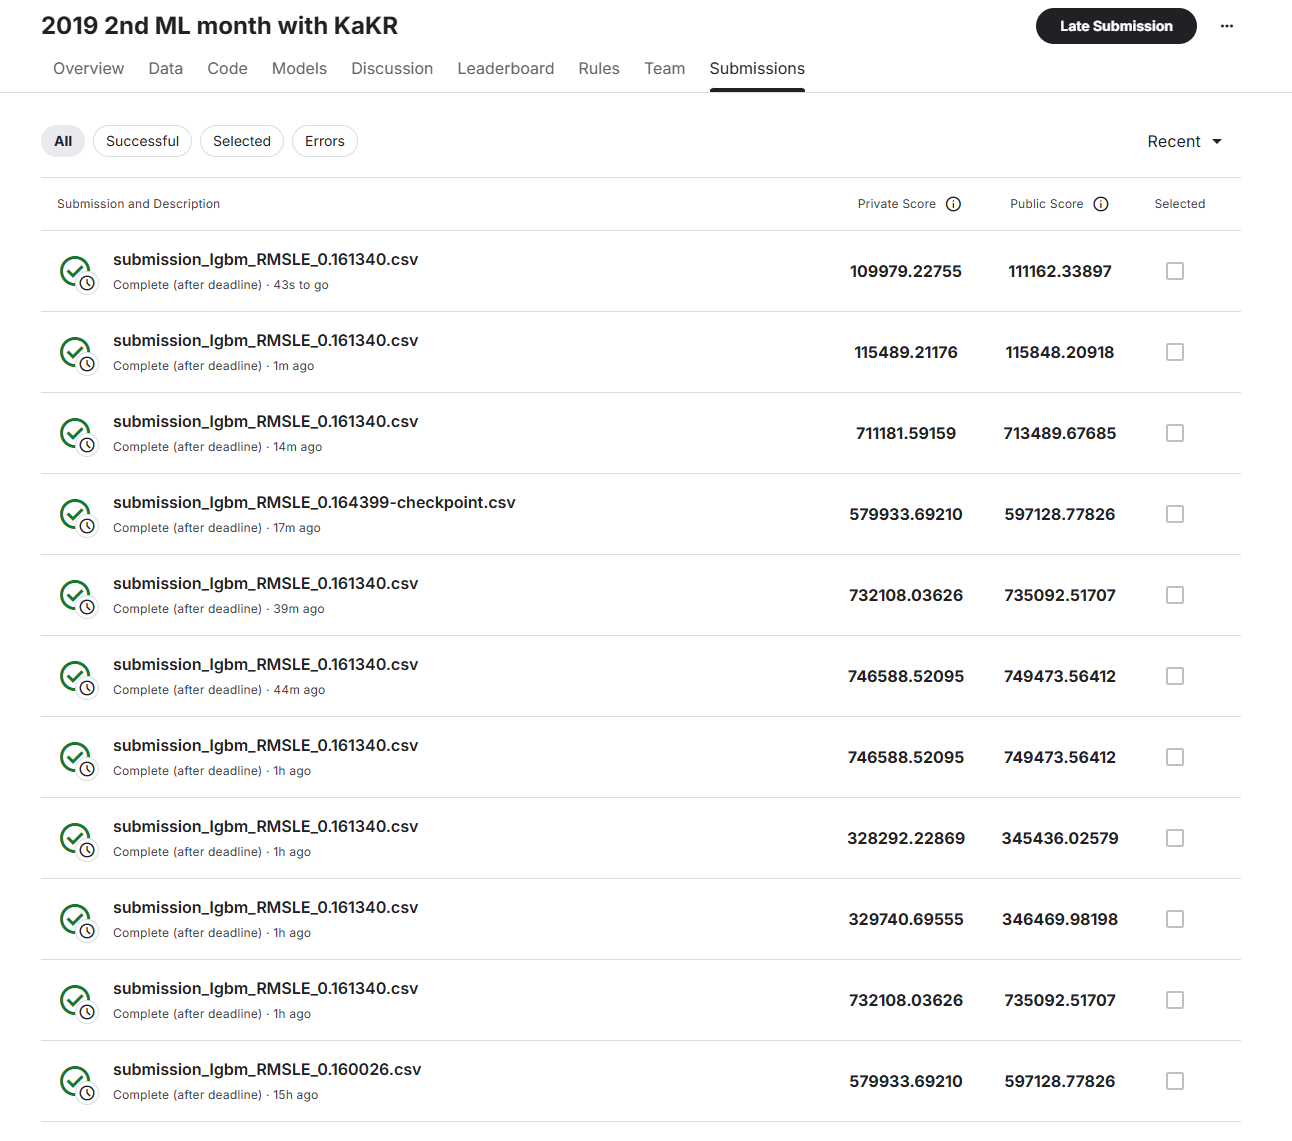